### Import libraries for experiments

In [164]:
import torch
from training_main import training_main, test
from utils import data_loading, normalization, filter_extraction, plot_results, plot_kernels
from CNN import CNN
from ScatNet import ScatNet2D
from kymatio.torch import Scattering2D
from skimage.segmentation import mark_boundaries

from lime.lime_image import LimeImageExplainer
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

from torchvision.transforms import ToTensor, Compose, Resize, Normalize, ToPILImage
from captum.attr import IntegratedGradients
import cv2

import warnings
warnings.filterwarnings('ignore')


## Data Loading and Normalization

In [99]:
# LOAD DATA
train_data, train_labels, test_data, test_labels = data_loading("./data/train/", "./data/test/")
data = train_data + test_data

# NORMALIZATION
data_transform = normalization(data)

Red ch mean =  0.2082946035683011 
Green ch mean =  0.2082298517705837 
Blue ch mean =  0.2082241406070435
Red ch std =  0.2120124417706629 
Green ch std =  0.211990008277464 
Blue ch std =  0.2119912744425195


In [100]:
print(f"Length train data: {len(train_data)}, length train labels: {len(train_labels)}")
print(f"Length test data: {len(test_data)}, length test labels: {len(test_labels)}")

Length train data: 2600, length train labels: 2600
Length test data: 600, length test labels: 600


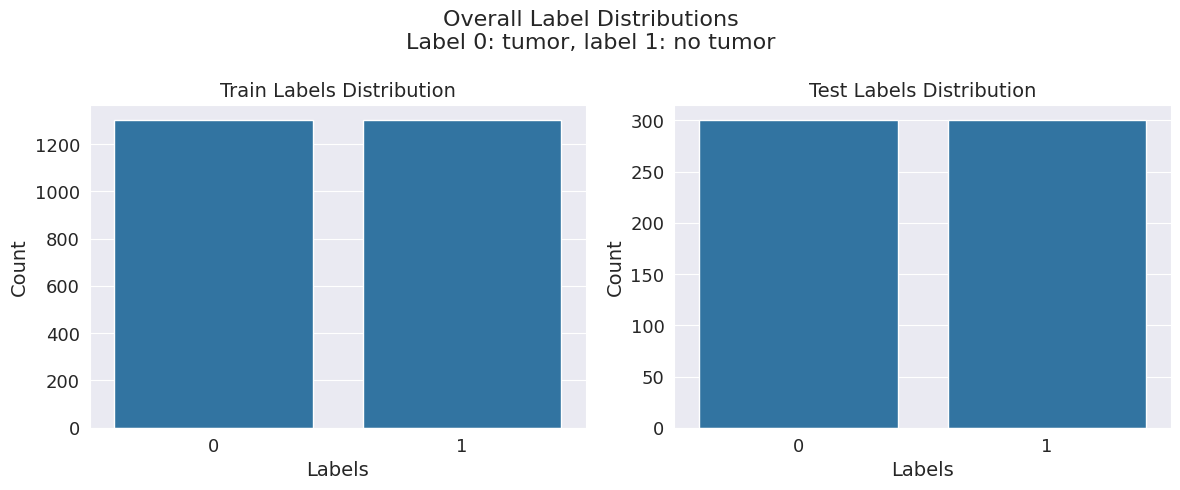

In [101]:
# Barplot to visualize the distribution of the labels 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Train labels
sns.countplot(x=train_labels, ax=ax1)
ax1.set_title('Train Labels Distribution', fontsize=14)
ax1.set_xlabel('Labels')
ax1.set_ylabel('Count')

# Test labels
sns.countplot(x=test_labels, ax=ax2)
ax2.set_title('Test Labels Distribution', fontsize=14)
ax2.set_xlabel('Labels')
ax2.set_ylabel('Count')

plt.suptitle('Overall Label Distributions\nLabel 0: tumor, label 1: no tumor', fontsize=16)
plt.tight_layout()
plt.show()


Example image

Image shape: (512, 512, 3)


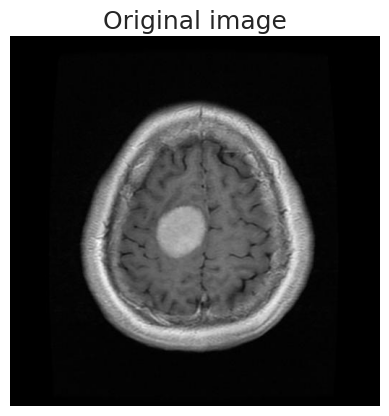

In [102]:
random.seed(42) 
image = random.sample(train_data, 1)
image = np.array(image)
image = np.squeeze(image, 0)
print(f"Image shape: {image.shape}")

plt.imshow(image)
plt.axis('off')
plt.title('Original image')
plt.show()

## CNN

In [103]:
MODEL_NAME = 'CNN'
NUM_FOLD = 10
num_epochs = 20

In [104]:
# LOAD BEST MODEL
max_val_accuracies = np.zeros([NUM_FOLD, 1])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    max_val_accuracies[i] = np.max(pd.read_csv(results_string)["val_acc"])
    
index = np.argmax(max_val_accuracies)

model_string = f"./models_trained/{MODEL_NAME}/checkpoint_" + str(index) + ".pth"
checkpoint = torch.load(model_string, map_location=torch.device("cpu"))
model_CNN = CNN(input_channel=3, num_classes=2)
model_CNN.load_state_dict(checkpoint["model_state_dict"])
for parameter in model_CNN.parameters():
    parameter.requires_grad = False


In [106]:
model_CNN

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=256, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [107]:
# PLOTTING RESULTS
val_accuracies = np.zeros([NUM_FOLD, num_epochs])
train_losses = np.zeros([NUM_FOLD, num_epochs])
val_losses = np.zeros([NUM_FOLD, num_epochs])
f1_scores = np.zeros([NUM_FOLD, num_epochs])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    val_accuracies[i] = (pd.read_csv(results_string)["val_acc"]).to_list()
    val_losses[i] = (pd.read_csv(results_string)["val_loss"]).to_list()
    train_losses[i] = (pd.read_csv(results_string)["train_loss"]).to_list()
    f1_scores[i] = (pd.read_csv(results_string)["val_f1"]).to_list()

plot_results(val_accuracies, train_losses, val_losses, f1_scores, MODEL_NAME)

Accuracy 0.9816666666666667


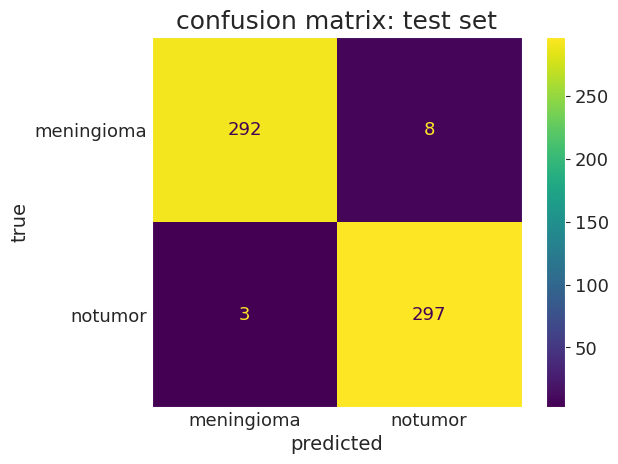

In [108]:
# TESTING
acc_CNN = test(data_transform, test_data, test_labels, model_CNN, MODEL_NAME, device='cpu')
print("Accuracy", acc_CNN)


### Extract Filters from CNN

In [109]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_CNN = model_CNN.to(device)


In [110]:
# Filter extraction
image = data_transform(image)
image = image.to(device)

single_channel = True if image.shape[0] == 1 else False
filter_extraction(model_CNN, MODEL_NAME, image, single_channel)

Total convolution layers: 4


## ScatNet 

In [111]:
MODEL_NAME = 'ScatNet'
NUM_FOLD = 10
num_epochs = 20

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [140]:
# LOAD BEST MODEL
max_val_accuracies = np.zeros([NUM_FOLD, 1])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    max_val_accuracies[i] = np.max(pd.read_csv(results_string)["val_acc"])
    
index = np.argmax(max_val_accuracies)

model_string = f"./models_trained/{MODEL_NAME}/checkpoint_" + str(index) + ".pth"
checkpoint = torch.load(model_string, map_location=torch.device("cpu"))

# Define best model
L = 8
J = 2
scattering = Scattering2D(J=J, shape=(128, 128), L=L)
K = 81  # Input channels for the ScatNet
scattering = scattering.to(device)
model_ScatNet = ScatNet2D(input_channels=K, scattering=scattering, num_classes=2).to(device)
model_ScatNet.load_state_dict(checkpoint["model_state_dict"])

for parameter in model_ScatNet.parameters():
    parameter.requires_grad = False

In [141]:
model_ScatNet

ScatNet2D(
  (scattering): Scattering2D()
  (lin): Linear(in_features=248832, out_features=576, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=576, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=32, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
    (5): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [142]:
# PLOTTING RESULTS
val_accuracies = np.zeros([NUM_FOLD, num_epochs])
train_losses = np.zeros([NUM_FOLD, num_epochs])
val_losses = np.zeros([NUM_FOLD, num_epochs])
f1_scores = np.zeros([NUM_FOLD, num_epochs])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    val_accuracies[i] = (pd.read_csv(results_string)["val_acc"]).to_list()
    val_losses[i] = (pd.read_csv(results_string)["val_loss"]).to_list()
    train_losses[i] = (pd.read_csv(results_string)["train_loss"]).to_list()
    f1_scores[i] = (pd.read_csv(results_string)["val_f1"]).to_list()

plot_results(val_accuracies, train_losses, val_losses, f1_scores, MODEL_NAME)

Accuracy 0.9666666666666667


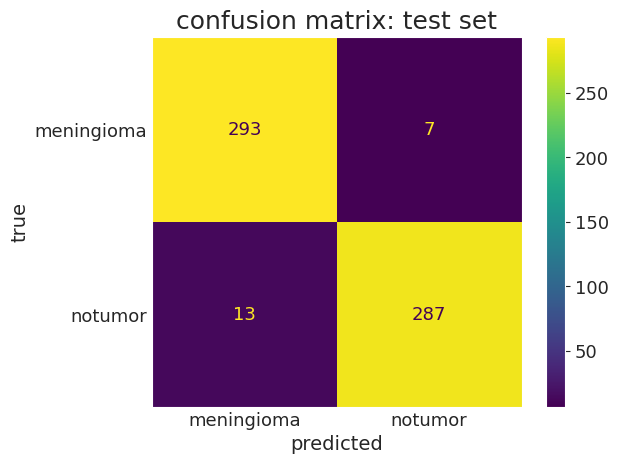

In [143]:
# TESTING
acc_ScatNet = test(data_transform, test_data, test_labels, model_ScatNet, MODEL_NAME, device='cpu')
print("Accuracy", acc_ScatNet)

### Extract Filters from ScatNet

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ScatNet = model_ScatNet.to(device)

In [ ]:
# Filter extraction
scatter = model_ScatNet.scattering
plot_kernels(J, L, scatter, MODEL_NAME)

--------------------------------------------------------------------
## INTEGRATED GRADIENTS

In [131]:
# IG SCRATCH
def ig_scratch(transformed_img, model, baseline, n_alpha):

    img = transformed_img.clone().to('cuda')
    baseline = baseline.to('cuda')
    model = model.to('cuda')

    difference_img_baseline = (img - baseline).squeeze(0).to('cuda')

    alphas = torch.linspace(0, 1, n_alpha + 1) 
    gradients_list = []

    model.eval()
    for alpha in alphas:
    
        baseline_x = baseline.unsqueeze(0).to('cuda')
        image_x = image.unsqueeze(0).to('cuda')
        difference_img_baseline = (image_x - baseline_x).to('cuda')
        input = baseline_x + alpha * difference_img_baseline

        model.zero_grad()
        input = input.clone().detach().requires_grad_(True)

        output = model(input.squeeze(0).to('cuda'))
        probs = torch.nn.functional.softmax(output, dim=1)[:,1]
        
        gradients = torch.autograd.grad(probs, input, 
                                    grad_outputs=torch.ones_like(probs),
                                    create_graph=True)[0]
        
        gradients_list.append(gradients)

    total_gradients = torch.cat(gradients_list, dim=0).to('cuda')
    grads = (total_gradients[:-1] + total_gradients[1:]) / torch.Tensor([2.0]).to('cuda')

    avg_gradients = torch.mean(grads.detach(), axis=0)
    integrated_gradients = (image - baseline) * avg_gradients

    integrated_gradients = torch.sum(torch.abs(integrated_gradients), dim=1)
    integrated_gradients = (integrated_gradients - torch.min(integrated_gradients)) / (torch.max(integrated_gradients) - torch.min(integrated_gradients))
    integrated_gradients = np.transpose(integrated_gradients.cpu().detach().numpy(), (1, 2, 0))

    return integrated_gradients
   

In [117]:
# IG CAPTUM
def ig_captum(transformed_img, model, baseline, n_alpha):
    img = transformed_img.to('cuda')
    model = model.to('cuda')
    baseline = baseline.to('cuda')

    ig = IntegratedGradients(model)
    attributions, delta = ig.attribute(img, baseline, target=0, return_convergence_delta=True, n_steps=n_alpha)

    attributions = torch.sum(torch.abs(attributions), dim=1)
    attributions = (attributions - torch.min(attributions)) / (torch.max(attributions) - torch.min(attributions))
    attributions = attributions.squeeze()

    return attributions

Test and plot the attributions for 3 different images from test folder.

In [118]:
random.seed(46)
num_images = 3
indices = random.sample(range(len(train_data)), num_images)

images = [train_data[i] for i in indices]
labels = [train_labels[i] for i in indices]


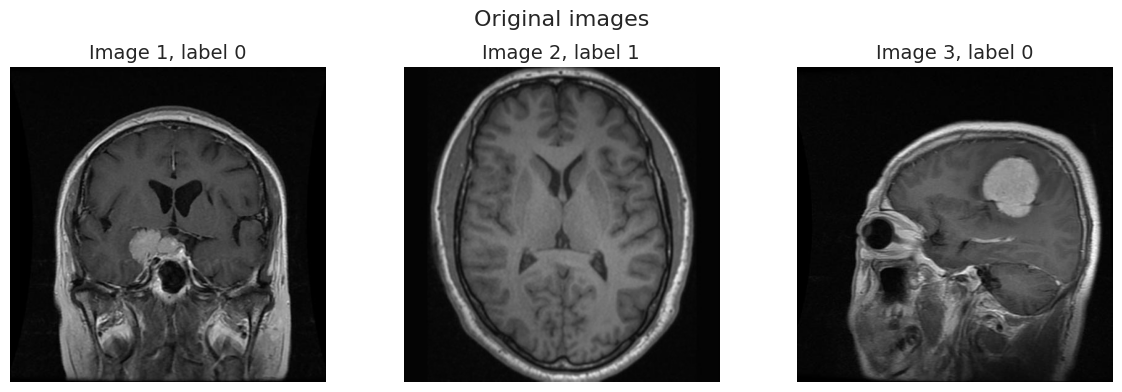

In [119]:
#Plot images
fig, axs = plt.subplots(1, num_images, figsize=(12, 4))

for i in range(num_images):
    image = images[i]
    label = labels[i]

    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title(f'Image {i+1}, label {label}', fontsize=14)

plt.suptitle('Original images', fontsize=16)
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


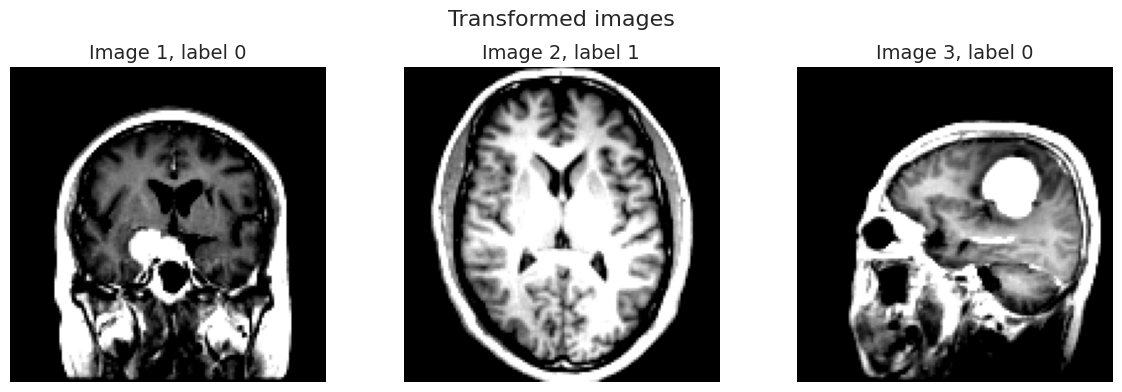

In [120]:
# Apply transform to images
for i in range(num_images):
    images[i] = data_transform(images[i]).unsqueeze(0)

# Plot
fig, axs = plt.subplots(1, num_images, figsize=(12, 4))
for i in range(num_images):
    image = np.squeeze(np.array(images[i]), 0).transpose(1, 2, 0)
    label = labels[i]
    
    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title(f'Image {i+1}, label {label}', fontsize=14)

plt.suptitle('Transformed images', fontsize=16)
plt.tight_layout()
plt.show()

### Baseline choices

In [121]:
baseline_zeros = torch.zeros(1, 3, 128, 128)
baseline_uniform = torch.rand(1, 3, 128, 128)

tensor_images = torch.stack([data_transform(img) for img in train_data])
baseline_mean = torch.mean(tensor_images, dim=0, keepdim=True)

baselines = [baseline_zeros, baseline_uniform, baseline_mean]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


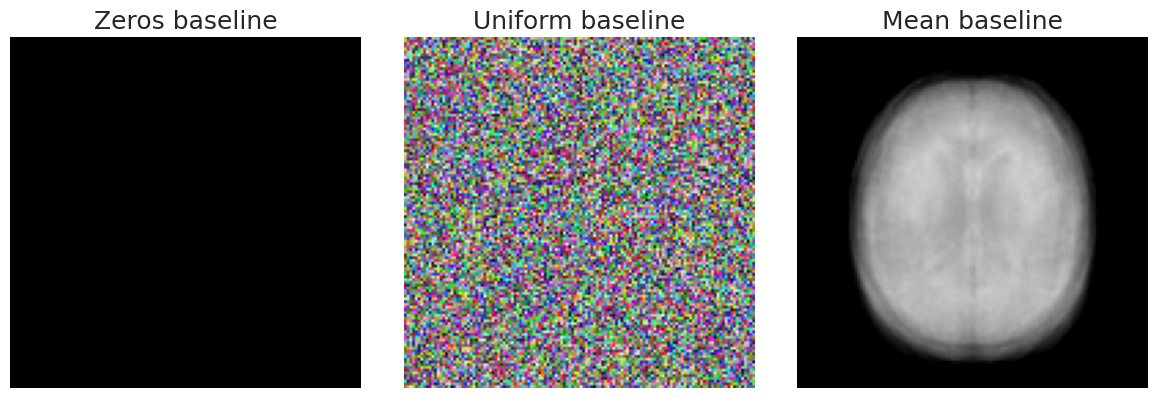

In [122]:
# Plot baselines
fig, axs = plt.subplots(1, len(baselines), figsize=(12, 4))
titles = ['Zeros baseline', 'Uniform baseline', 'Mean baseline']

for i in range(len(baselines)):
    baseline = baselines[i]

    axs[i].imshow(baseline.squeeze().permute(1, 2, 0))
    axs[i].axis('off')
    axs[i].set_title(f'{titles[i]}')

plt.tight_layout()
plt.show()

### How to plot attributions

In [127]:
# Attribution plot
def plot_attributions(image, baselines, attributions, titles):

    image = image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    fig, axis = plt.subplots(len(baselines), 3, figsize=(12, 10))
    
    for i in range(len(baselines)):
        attribution = attributions[i]
        baseline_plot = baselines[i].squeeze().permute(1, 2, 0)
        ig_captum = attribution[0].cpu()
        ig_scratch = attribution[1]

        axis[i, 0].imshow(baseline_plot)
        axis[i, 0].set_xticks([])
        axis[i, 0].set_yticks([])
        axis[i, 0].set_title(titles[i], fontsize=14)

        im2 = axis[i, 1].imshow(image)
        im2 = axis[i, 1].imshow(ig_captum, cmap='inferno', alpha=0.9)
        axis[i, 1].axis('off')
        axis[i, 1].set_title('IG Captum', fontsize=14)
        divider = make_axes_locatable(axis[i, 1])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im2, cax=cax, orientation='vertical')

        im3 = axis[i, 2].imshow(image)
        im3 = axis[i, 2].imshow(ig_scratch, cmap='inferno', alpha=0.9)
        axis[i, 2].axis('off')
        axis[i, 2].set_title('IG Scratch', fontsize=14)

        divider = make_axes_locatable(axis[i, 2])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im3, cax=cax, orientation='vertical')
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    plt.show()

### Attributions for CNN model

In [153]:
# ScatNet model
print('CNN MODEL')
for i in range(num_images):
    print(f'Image {i+1}')
    image = images[i].to('cuda')
    label = labels[i]

    model_CNN.eval()
    with torch.inference_mode():
        pred = model_CNN(image)
        
    probs = torch.softmax(pred, dim=1)
    prediction = torch.argmax(torch.softmax(pred, dim=1), dim=1)

    # model logits -> pred probs -> pred label
    print("Output logits: ", pred)
    print("Output prediction probabilities: ", probs)
    print(f'Output prediction label: {prediction} --> Prediction class: {"NO TUMOR" if prediction.cpu() == 1 else "TUMOR"}')
    print(f'Actual label: {label} --> True class: {"NO TUMOR" if label == 1 else "TUMOR"}\n')

CNN MODEL
Image 1
Output logits:  tensor([[ 17.2301, -17.2466]], device='cuda:0')
Output prediction probabilities:  tensor([[1.0000e+00, 1.0641e-15]], device='cuda:0')
Output prediction label: tensor([0], device='cuda:0') --> Prediction class: TUMOR
Actual label: 0 --> True class: TUMOR

Image 2
Output logits:  tensor([[-1.0114,  3.5225]], device='cuda:0')
Output prediction probabilities:  tensor([[0.0106, 0.9894]], device='cuda:0')
Output prediction label: tensor([1], device='cuda:0') --> Prediction class: NO TUMOR
Actual label: 1 --> True class: NO TUMOR

Image 3
Output logits:  tensor([[ 8.6464, -8.1467]], device='cuda:0')
Output prediction probabilities:  tensor([[1.0000e+00, 5.0917e-08]], device='cuda:0')
Output prediction label: tensor([0], device='cuda:0') --> Prediction class: TUMOR
Actual label: 0 --> True class: TUMOR



Image 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


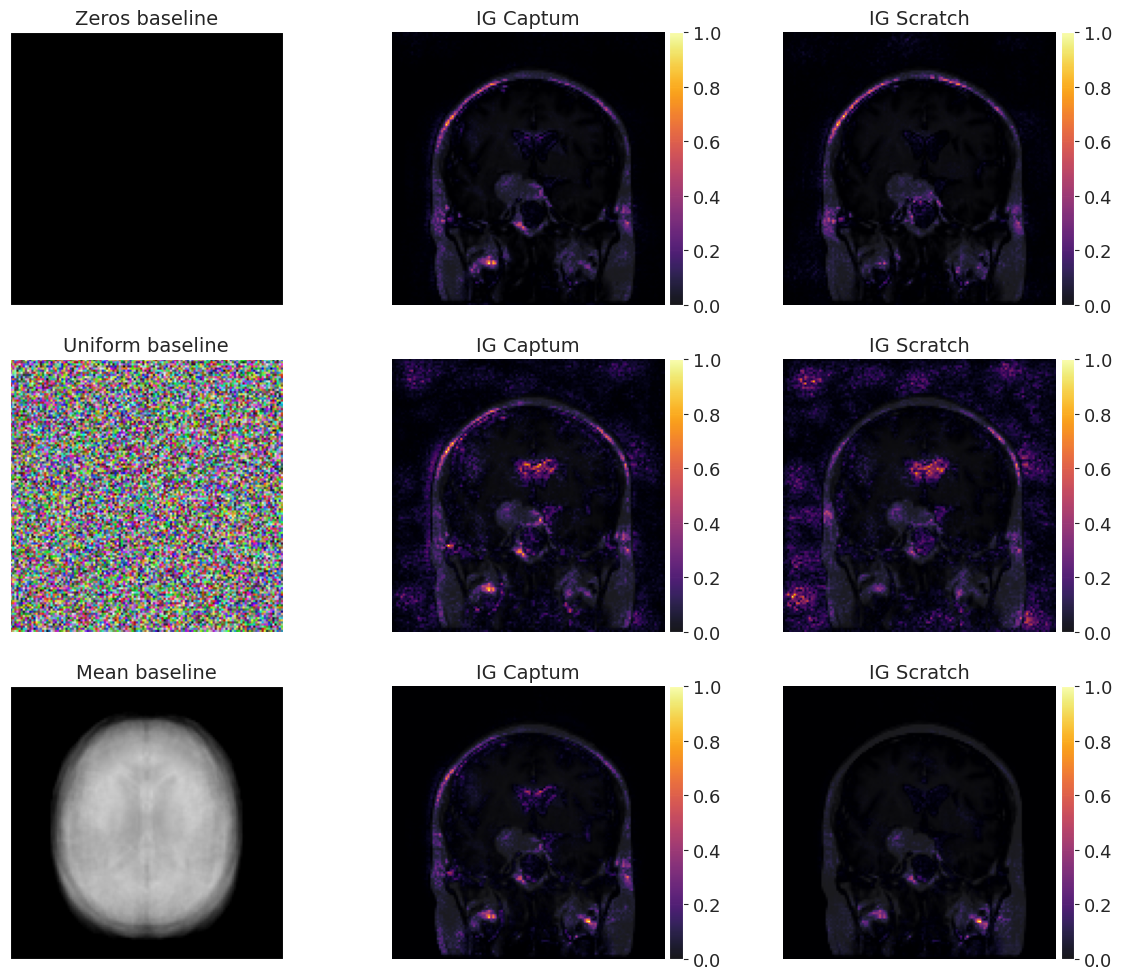

Image 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


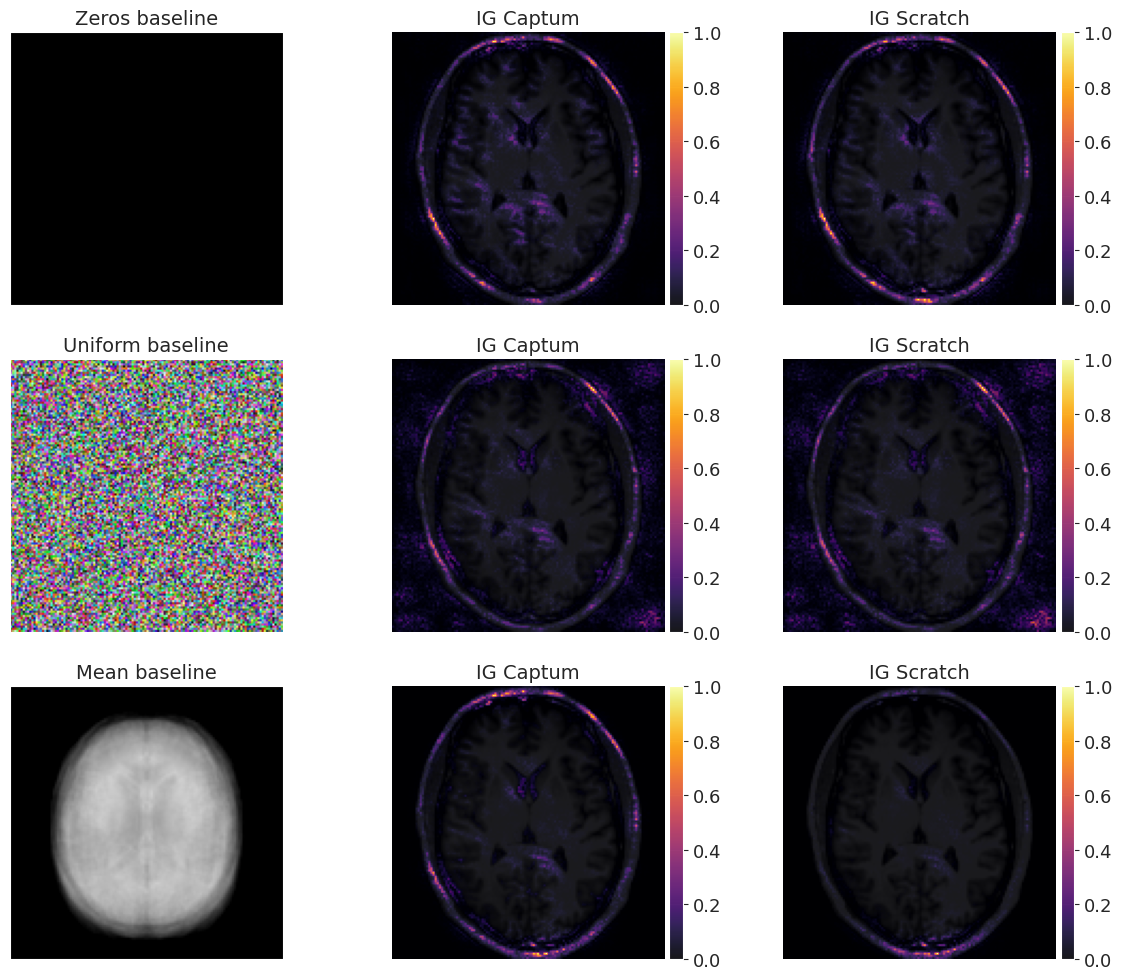

Image 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


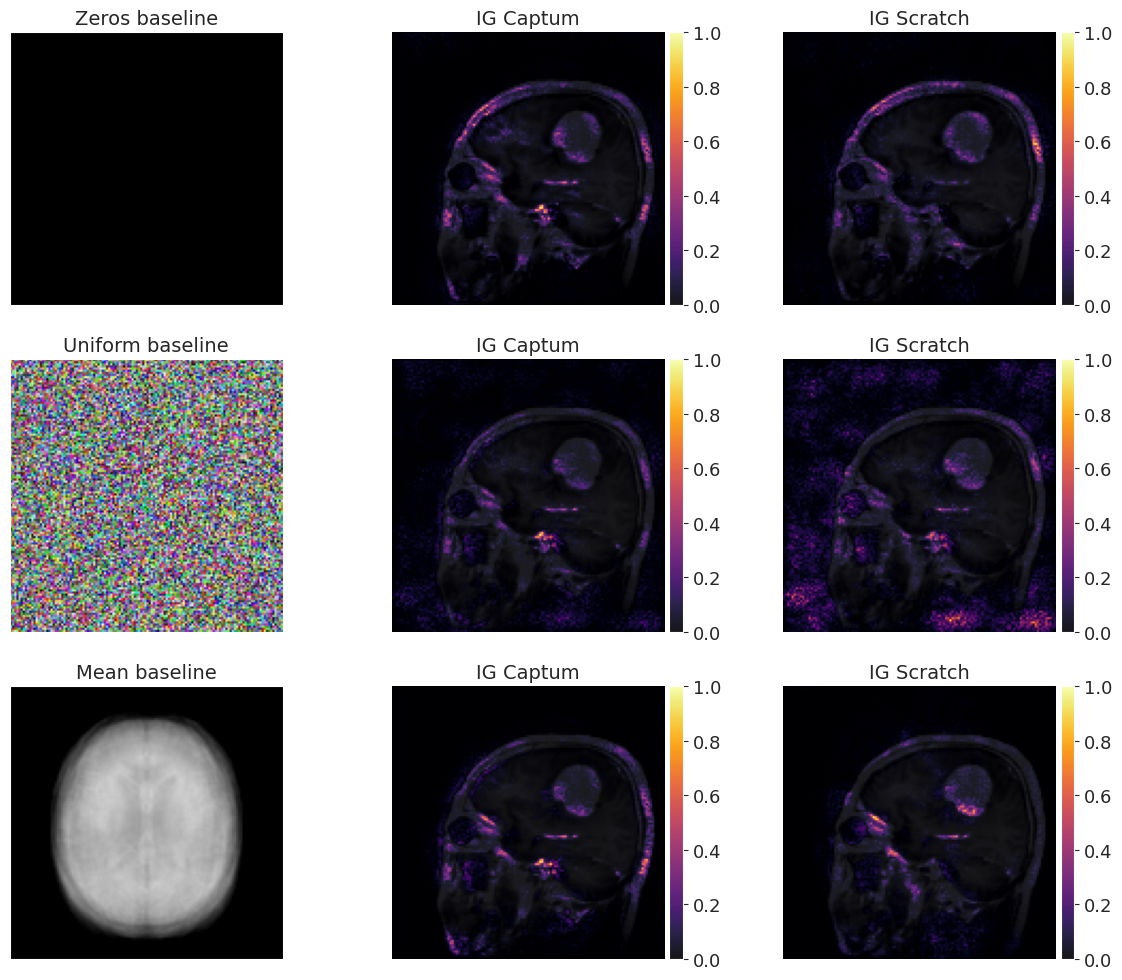

In [154]:
# Compute Integrated Gradients attributions for each baseline (Captum and scratch)
for i in range(num_images):
    print(f'Image {i+1}')
    image = images[i].to('cuda')
    
    attributions = []
    for i in range(len(baselines)):
        attribution_baseline = []

        baseline = baselines[i]
        attribution_captum = ig_captum(image, model_CNN, baseline, n_alpha)
        attribution_baseline.append(attribution_captum)
        attribution_scratch = ig_scratch(image, model_CNN, baseline, n_alpha)
        attribution_baseline.append(attribution_scratch)
        
        attributions.append(attribution_baseline)

    plot_attributions(image, baselines, attributions, titles)

### Attributions for ScatNet model

In [146]:
# ScatNet model
print('SCATNET MODEL')
for i in range(num_images):
    print(f'Image {i+1}')
    image = images[i].to('cuda')
    label = labels[i]

    model_ScatNet.eval()
    with torch.inference_mode():
        pred = model_ScatNet(image)
        
    probs = torch.softmax(pred, dim=1)
    prediction = torch.argmax(torch.softmax(pred, dim=1), dim=1)

    # model logits -> pred probs -> pred label
    print("Output logits: ", pred)
    print("Output prediction probabilities: ", probs)
    print(f'Output prediction label: {prediction} --> Prediction class: {"NO TUMOR" if prediction.cpu() == 1 else "TUMOR"}')
    print(f'Actual label: {label} --> True class: {"NO TUMOR" if label == 1 else "TUMOR"}\n')

SCATNET MODEL
Image 1
Output logits:  tensor([[11.7184, -1.9289]], device='cuda:0')
Output prediction probabilities:  tensor([[1.0000e+00, 1.1831e-06]], device='cuda:0')
Output prediction label: tensor([0], device='cuda:0') --> Prediction class: TUMOR
Actual label: 0 --> True class: TUMOR

Image 2
Output logits:  tensor([[-0.2571,  4.1110]], device='cuda:0')
Output prediction probabilities:  tensor([[0.0125, 0.9875]], device='cuda:0')
Output prediction label: tensor([1], device='cuda:0') --> Prediction class: NO TUMOR
Actual label: 1 --> True class: NO TUMOR

Image 3
Output logits:  tensor([[11.0494, -0.9510]], device='cuda:0')
Output prediction probabilities:  tensor([[9.9999e-01, 6.1422e-06]], device='cuda:0')
Output prediction label: tensor([0], device='cuda:0') --> Prediction class: TUMOR
Actual label: 0 --> True class: TUMOR



Image 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


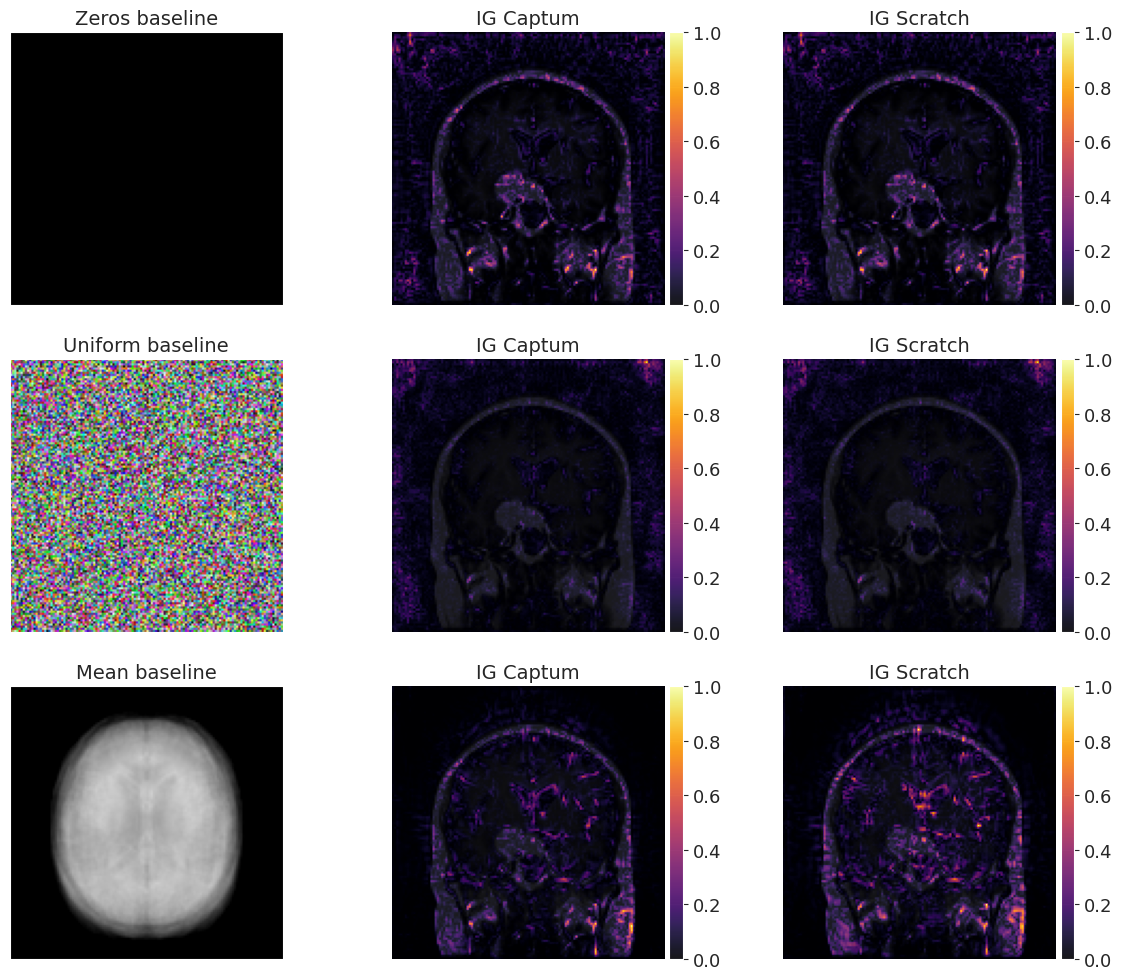

Image 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


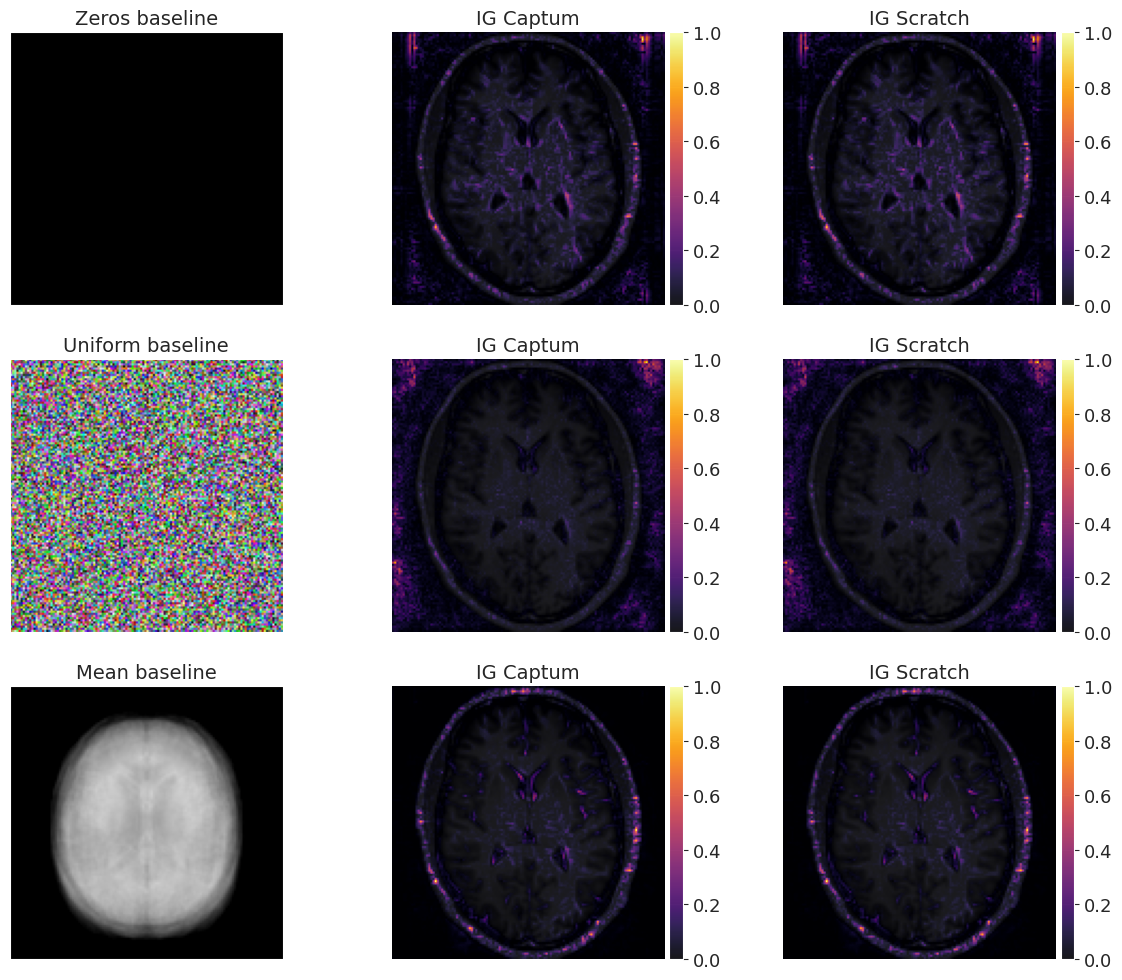

Image 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


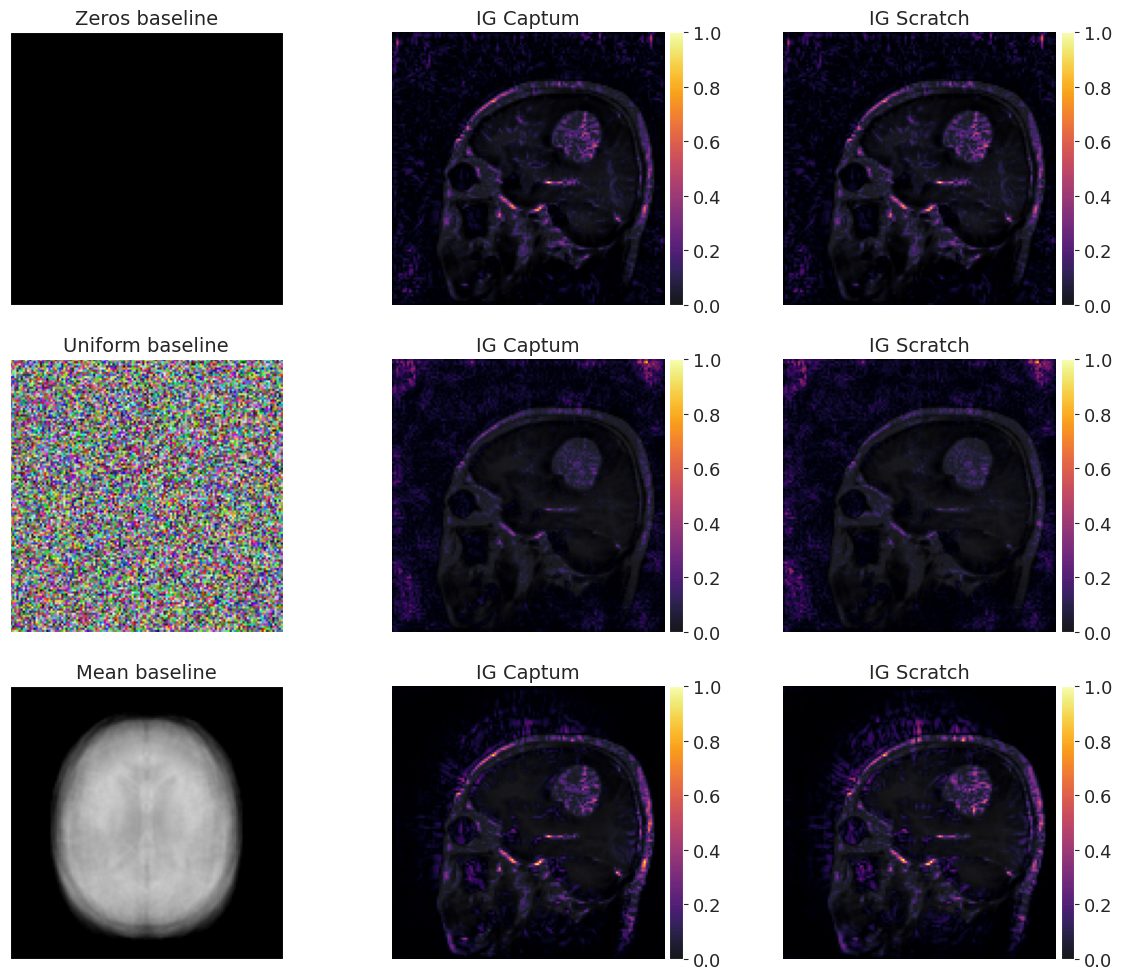

In [152]:
# Compute Integrated Gradients attributions for each baseline (Captum and scratch)
for i in range(num_images):
    print(f'Image {i+1}')
    image = images[i].to('cuda')
    
    attributions = []
    for i in range(len(baselines)):
        attribution_baseline = []

        baseline = baselines[i]
        attribution_captum = ig_captum(image, model_ScatNet, baseline, n_alpha)
        attribution_baseline.append(attribution_captum)
        attribution_scratch = ig_scratch(image, model_ScatNet, baseline, n_alpha)
        attribution_baseline.append(attribution_scratch)
        
        attributions.append(attribution_baseline)

    plot_attributions(image, baselines, attributions, titles)